This code runs version 1.4.1 of the FaIR climate model and is built off the temperature-attribution repository developed by Chris Smith: https://github.com/chrisroadmap/temperature-attribution/tree/main

To set up an environment to run the code:

1) clone the temperature-attribution repository and cd to temperature-attribution
2) create the environment using conda env create -f environment.yml (optional if needed)
3) activate the environment with conda activate temperature-attribution (optional if needed)
4) run nbstripout --install to ensure clean notebook commits (optional if needed)
5) download this jupyter notebook and put the notebook in the notebooks directory

In [1]:
#Import required packages

import numpy as np
import pandas as pd
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

/Users/hausfath/.pyenv/versions/3.11.6/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Define functions for the different FaIR runs and analyses

def run_fair(emissions_file, forcing_file, scenarios, adjust = False, emissions_adj_co2 = np.array([]), emissions_adj_ch4 = np.array([])):
    #f = FAIR()
    f = FAIR(ch4_method="Thornhill2021")
    f.define_time(1750, 2500, 1)  # start, end, step
    f.define_scenarios(scenarios)
    fair_params_1_4_1_file = '../data/calibrated_constrained_ensemble/calibrated_constrained_parameters_calibration1.4.1.csv'
    df_configs = pd.read_csv(fair_params_1_4_1_file, index_col=0)
    configs = df_configs.index  # this is used as a label for the "config" axis
    f.define_configs(configs)
    fair_species_configs_1_4_1_file = '../data/calibrated_constrained_ensemble/species_configs_properties_calibration1.4.1.csv'
    species, properties = read_properties(filename=fair_species_configs_1_4_1_file)
    f.define_species(species, properties)
    f.allocate()
    f.fill_from_csv(
        emissions_file='../data/calibrated_constrained_ensemble/'+emissions_file,
        forcing_file='../data/calibrated_constrained_ensemble/'+forcing_file,
    )

    #Code to add a custom array to the default emissions data for both CO2 and CH4
    if adjust == True:
        time_mask   = f.emissions['timepoints'] >= 2025
        time_sel    = f.emissions['timepoints'].where(time_mask, drop=True)
        n_years     = time_sel.size
        
        adj_trimmed_co2 = emissions_adj_co2[:n_years]
        adj_da_co2 = xr.DataArray(
            adj_trimmed_co2,
            coords={'timepoints': time_sel},
            dims='timepoints'
        )
        co2_slice = dict(timepoints=time_sel, specie='CO2 FFI')
        
        f.emissions.loc[co2_slice] = (
            f.emissions.sel(**co2_slice) + adj_da_co2
        )

        adj_trimmed_ch4 = emissions_adj_ch4[:n_years]
        adj_da_ch4 = xr.DataArray(
            adj_trimmed_ch4,
            coords={'timepoints': time_sel},
            dims='timepoints'
        )
        ch4_slice = dict(timepoints=time_sel, specie='CH4')

        f.emissions.loc[ch4_slice] = (
            f.emissions.sel(**ch4_slice) + adj_da_ch4
        )
    
    fill(
        f.forcing,
        f.forcing.sel(specie="Volcanic") * df_configs["forcing_scale[Volcanic]"].values.squeeze(),
        specie="Volcanic",
    )
    fill(
        f.forcing,
        f.forcing.sel(specie="Solar") * df_configs["forcing_scale[Solar]"].values.squeeze(),
        specie="Solar",
    )
    f.fill_species_configs(fair_species_configs_1_4_1_file)
    f.override_defaults(fair_params_1_4_1_file)
    initialise(f.concentration, f.species_configs["baseline_concentration"])
    initialise(f.forcing, 0)
    initialise(f.temperature, 0)
    initialise(f.cumulative_emissions, 0)
    initialise(f.airborne_emissions, 0)
    initialise(f.ocean_heat_content_change, 0)
    f.run()
    return f


def diffs_export_csv(f, ff, scenario_selected, label_name, ylabel_name, csv_file):
    # ensure scalar scenario (works if user passed ['low'])
    if not isinstance(scenario_selected, str):
        scenario_selected = np.asarray(scenario_selected).ravel()[0]

    t_ff = ff.temperature.sel(scenario=scenario_selected, layer=0).squeeze(drop=True)
    t_f  =  f.temperature.sel(scenario=scenario_selected, layer=0).squeeze(drop=True)
    temp_diff = t_ff - t_f

    f_ff = ff.forcing_sum.sel(scenario=scenario_selected).squeeze(drop=True)
    f_f  =  f.forcing_sum.sel(scenario=scenario_selected).squeeze(drop=True)
    forcing_diff = f_ff - f_f

    def qdf(diff):
        # Compute all three at once; remaining dim is the time-like dim (name-agnostic)
        q = diff.quantile([0.05, 0.50, 0.95], dim="config")
        time_dim = [d for d in q.dims if d != "quantile"][0]
        # Put time on rows, quantiles on columns and convert to pandas
        df = q.transpose(time_dim, "quantile").to_pandas()
        df.columns = ["diffs_05", "diffs_50", "diffs_95"]
        return df

    df_out_temperature = qdf(temp_diff)
    df_out_forcing     = qdf(forcing_diff)

    df_out_temperature.to_csv(csv_file)
    df_out_forcing.to_csv("forcing_" + csv_file)
    

def difference_scenarios(f, co2_perturbation, ch4_perturbation, scenarios, savenames):
    ff = run_fair('extensions_1750-2500.csv', 'volcanic_solar.csv', scenarios, True, co2_perturbation, ch4_perturbation)
    diffs_export_csv(f, ff, scenarios, 'CDR Temperature Effects', 
                    '°C relative to baseline scenario', savenames+'.csv')

    # handle list-like scenarios robustly
    for scen in np.atleast_1d(scenarios):
        scen = np.asarray([scen]).ravel()[0]   # ensure scalar label
        diffs_export_csv(f, ff, scen,
                         'CDR Temperature Effects',
                         '°C relative to baseline scenario',
                         f'{savenames}_{scen}.csv')

In [3]:
#Baseline model run and constants

#Scenario selected
scenarios = ['low']
n_years = 20  # number of annual pulses in the cumulative experiment

#No CH4 perturbation in these experiments
emissions_only_ch4 = [0] #35.71
ch4_perturbation = np.r_[emissions_only_ch4, np.full(1000, 0)]

#Run baseline model
f = run_fair('extensions_1750-2500.csv', 'volcanic_solar.csv', scenarios)

Running 841 projections in parallel: 100%|█| 750/750 [00:04<00:00, 171.77times


In [4]:
#Scenario 0: Baseline emissions (1 GtCO2)

emissions_co2 = [1]
co2_perturbation_pulse = np.r_[emissions_co2, np.full(1000, 0)]   # long tail of 0s
co2_cumulative = np.convolve(emissions_co2, np.ones(n_years, dtype=float), mode='full')
co2_perturbation_cumulative = np.r_[co2_cumulative, np.full(1000, 0)]   # long tail of 0s

#Do the pulse run
savenames = 'baseline_emissions_pulse'
difference_scenarios(f, co2_perturbation_pulse, ch4_perturbation, scenarios, savenames)

#Do the cumulative run
savenames = 'baseline_emissions_cumulative'
difference_scenarios(f, co2_perturbation_cumulative, ch4_perturbation, scenarios, savenames)


Running 841 projections in parallel: 100%|█| 750/750 [00:04<00:00, 170.44times
Running 841 projections in parallel: 100%|█| 750/750 [00:04<00:00, 156.17times


In [5]:
#Scenario 1: Physical delay

#First run for CDR only
cdr_only = [-0.05, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, 
            -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05]
co2_perturbation_pulse = np.r_[cdr_only, np.full(1000, 0)]   # long tail of 0s
co2_cumulative = np.convolve(cdr_only, np.ones(n_years, dtype=float), mode='full')
co2_perturbation_cumulative = np.r_[co2_cumulative, np.full(1000, 0)]   # long tail of 0s

#Do the pulse run
savenames = 'physical_delay_cdr_only_pulse'
difference_scenarios(f, co2_perturbation_pulse, ch4_perturbation, scenarios, savenames)

#Do the cumulative run
savenames = 'physical_delay_cdr_only_cumulative'
difference_scenarios(f, co2_perturbation_cumulative, ch4_perturbation, scenarios, savenames)


#Second run for CDR and emissions
cdr_emissions = [0.95, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, 
            -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05]
co2_perturbation_pulse = np.r_[cdr_emissions, np.full(1000, 0)]   # long tail of 0s
co2_cumulative = np.convolve(cdr_emissions, np.ones(n_years, dtype=float), mode='full')
co2_perturbation_cumulative = np.r_[co2_cumulative, np.full(1000, 0)]   # long tail of 0s

#Do the pulse run
savenames = 'physical_delay_cdr_emissions_pulse'
difference_scenarios(f, co2_perturbation_pulse, ch4_perturbation, scenarios, savenames)

#Do the cumulative run
savenames = 'physical_delay_cdr_emissions_cumulative'
difference_scenarios(f, co2_perturbation_cumulative, ch4_perturbation, scenarios, savenames)

Running 841 projections in parallel: 100%|█| 750/750 [00:04<00:00, 154.53times
Running 841 projections in parallel: 100%|█| 750/750 [00:04<00:00, 166.01times
Running 841 projections in parallel: 100%|█| 750/750 [00:04<00:00, 162.97times
Running 841 projections in parallel: 100%|█| 750/750 [00:04<00:00, 164.41times


In [6]:
#Scenario 2: Counterfactual delay

#First run for CDR only
cdr_only = [-0.05, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, 
            -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05]
co2_perturbation_pulse = np.r_[cdr_only, np.full(1000, 0)]   # long tail of 0s
co2_cumulative = np.convolve(cdr_only, np.ones(n_years, dtype=float), mode='full')
co2_perturbation_cumulative = np.r_[co2_cumulative, np.full(1000, 0)]   # long tail of 0s

#Do the pulse run
savenames = 'counterfactual_delay_cdr_only_pulse'
difference_scenarios(f, co2_perturbation_pulse, ch4_perturbation, scenarios, savenames)

#Do the cumulative run
savenames = 'counterfactual_delay_cdr_only_cumulative'
difference_scenarios(f, co2_perturbation_cumulative, ch4_perturbation, scenarios, savenames)


#Second run for CDR and emissions
cdr_emissions = [0.95, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, 
                -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05]
co2_perturbation_pulse = np.r_[cdr_emissions, np.full(1000, 0)]   # long tail of 0s
co2_cumulative = np.convolve(cdr_emissions, np.ones(n_years, dtype=float), mode='full')
co2_perturbation_cumulative = np.r_[co2_cumulative, np.full(1000, 0)]   # long tail of 0s

#Do the pulse run
savenames = 'counterfactual_delay_cdr_emissions_pulse'
difference_scenarios(f, co2_perturbation_pulse, ch4_perturbation, scenarios, savenames)

#Do the cumulative run
savenames = 'counterfactual_delay_cdr_emissions_cumulative'
difference_scenarios(f, co2_perturbation_cumulative, ch4_perturbation, scenarios, savenames)

Running 841 projections in parallel: 100%|█| 750/750 [00:05<00:00, 144.13times
Running 841 projections in parallel: 100%|█| 750/750 [00:04<00:00, 157.47times
Running 841 projections in parallel: 100%|█| 750/750 [00:05<00:00, 125.38times
Running 841 projections in parallel: 100%|█| 750/750 [00:04<00:00, 159.07times


In [7]:
#Scenario 3: Accelerated emissions

#First run for CDR only
cdr_only = [0.9, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,
            -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]
co2_perturbation_pulse = np.r_[cdr_only, np.full(1000, 0)]   # long tail of 0s
co2_cumulative = np.convolve(cdr_only, np.ones(n_years, dtype=float), mode='full')
co2_perturbation_cumulative = np.r_[co2_cumulative, np.full(1000, 0)]   # long tail of 0s

#Do the pulse run
savenames = 'accelerated_emissions_cdr_only_pulse'
difference_scenarios(f, co2_perturbation_pulse, ch4_perturbation, scenarios, savenames)

#Do the cumulative run
savenames = 'accelerated_emissions_cdr_only_cumulative'
difference_scenarios(f, co2_perturbation_cumulative, ch4_perturbation, scenarios, savenames)


#Second run for CDR and emissions
cdr_emissions = [1.9, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,
                -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]
co2_perturbation_pulse = np.r_[cdr_emissions, np.full(1000, 0)]   # long tail of 0s
co2_cumulative = np.convolve(cdr_emissions, np.ones(n_years, dtype=float), mode='full')
co2_perturbation_cumulative = np.r_[co2_cumulative, np.full(1000, 0)]   # long tail of 0s

#Do the pulse run
savenames = 'accelerated_emissions_cdr_emissions_pulse'
difference_scenarios(f, co2_perturbation_pulse, ch4_perturbation, scenarios, savenames)

#Do the cumulative run
savenames = 'accelerated_emissions_cdr_emissions_cumulative'
difference_scenarios(f, co2_perturbation_cumulative, ch4_perturbation, scenarios, savenames)

Running 841 projections in parallel: 100%|█| 750/750 [00:05<00:00, 145.64times
Running 841 projections in parallel: 100%|█| 750/750 [00:04<00:00, 166.70times
Running 841 projections in parallel: 100%|█| 750/750 [00:04<00:00, 163.79times
Running 841 projections in parallel: 100%|█| 750/750 [00:04<00:00, 151.90times


In [8]:
#Scenario 4: Upfront embodied emissions (note, no pulse runs are possible here)

#First run for CDR only
cdr_only = [3, -1.15, -1.15, -1.15, -1.15, -1.15, -1.15, -1.15, -1.15 -1.15, -1.15, 
            -1.15, -1.15, -1.15, -1.15, -1.15, -1.15, -1.15, -1.15, -1.15, -1.15]
co2_perturbation_cumulative = np.r_[cdr_only, np.full(1000, 0)]   # long tail of 0s

#Do the cumulative run
savenames = 'upfront_emissions_cdr_only_cumulative'
difference_scenarios(f, co2_perturbation_cumulative, ch4_perturbation, scenarios, savenames)

cdr_only = [3, -0.15, -0.15, -0.15, -0.15, -0.15, -0.15, -0.15, -0.15 -0.15, -0.15, 
            -0.15, -0.15, -0.15, -0.15, -0.15, -0.15, -0.15, -0.15, -0.15, -0.15]
co2_perturbation_cumulative = np.r_[cdr_only, np.full(1000, 0)]   # long tail of 0s

#Do the cumulative run
savenames = 'upfront_emissions_cdr_emissions_cumulative'
difference_scenarios(f, co2_perturbation_cumulative, ch4_perturbation, scenarios, savenames)

Running 841 projections in parallel: 100%|█| 750/750 [00:04<00:00, 150.28times
Running 841 projections in parallel: 100%|█| 750/750 [00:05<00:00, 131.38times


(PosixPath('cdr_20yr_cumulative_panels.png'),
 PosixPath('cdr_20yr_cumulative_panels.pdf'),
 [])

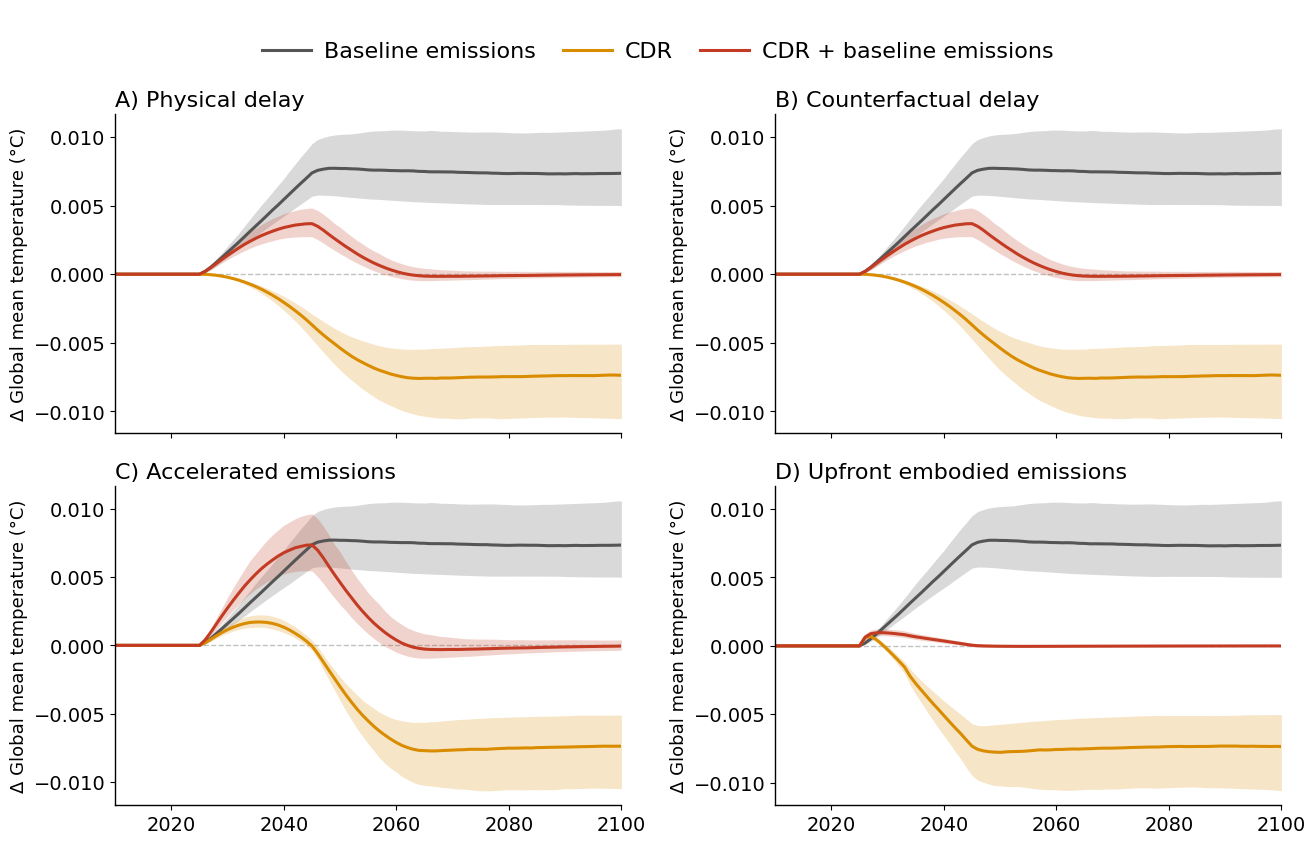

In [9]:
# Fix: Only create a shared legend if we actually have plotted lines.
# Re-run the panel plotting so it renders even if inputs are missing.
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path

def graph_CDR_panels(panels, panel_titles, savename_base, 
                     year_min=2000, year_max=2100):
    plt.style.use('default')
    mpl.rcParams.update({
        'font.family'    : 'DejaVu Sans',
        'axes.grid'      : False,
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.linewidth' : 1.0,
        'legend.frameon' : False,
        "font.size": 16,        # base font
        "axes.titlesize": 18,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "lines.linewidth": 3,
    })
    

    fig, axs = plt.subplots(2, 2, figsize=(14, 9), sharex=True, sharey=False)
    axs = axs.ravel()

    shared_handles, shared_labels = [], []
    all_missing = []

    for ax, scenarios, title in zip(axs, panels, panel_titles):
        ax.set_title(title, loc="left", fontsize=16)
        missing_files = []

        for case in scenarios:
            fpath = Path(case["file"])
            if not fpath.exists():
                missing_files.append(str(fpath))
                continue

            df = pd.read_csv(fpath)
            df.rename(columns={'Unnamed: 0': 'Year'}, inplace=True)
            if 'Year' not in df.columns:
                if df.columns[0].lower().startswith('year'):
                    df.rename(columns={df.columns[0]: 'Year'}, inplace=True)
                elif df.columns[0].lower().startswith('timebounds'):
                    df.rename(columns={df.columns[0]: 'Year'}, inplace=True)
            df = df[(df['Year'] >= year_min) & (df['Year'] <= year_max)]
            ax.fill_between(df['Year'], df['diffs_05'], df['diffs_95'],
                            color=case["color"], alpha=0.22, linewidth=0)
            line, = ax.plot(df['Year'], df['diffs_50'],
                            color=case["color"], lw=2.2, label=case["label"])

            shared_handles.append(line)
            shared_labels.append(case["label"])

        ax.set_xlim(year_min, year_max)
        ax.set_xlabel('', fontsize=13)
        ax.set_ylabel('Δ Global mean temperature (°C)', fontsize=13)
        ax.axhline(0, color='0.6', lw=1.0, ls='--', alpha=0.6, zorder=0)

        if missing_files:
            all_missing.extend(missing_files)
            msg = "Missing files:\n" + "\n".join(Path(m).name for m in missing_files)
            ax.text(0.5, 0.5, msg, transform=ax.transAxes,
                    ha='center', va='center', fontsize=11,
                    bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.85))

    # Deduplicate legend entries
    seen = set()
    uniq_handles, uniq_labels = [], []
    for h, l in zip(shared_handles, shared_labels):
        if l not in seen:
            uniq_handles.append(h); uniq_labels.append(l); seen.add(l)

    if len(uniq_labels) > 0:
        fig.legend(uniq_handles, uniq_labels, loc='upper center',
                   ncol=len(uniq_labels), borderaxespad=1.5,
                   handlelength=2.2, handletextpad=0.6, columnspacing=1.2)
    
    fig.tight_layout(rect=[0.02, 0.02, 0.98, 0.90])

    out_png = Path(f"{savename_base}.png")
    out_pdf = Path(f"{savename_base}.pdf")
    fig.savefig(out_png, dpi=500, bbox_inches='tight')
    fig.savefig(out_pdf, bbox_inches='tight')
    return out_png, out_pdf, all_missing

# Use the same panel configuration as before
panels = [
    [
        {"file": "baseline_emissions_cumulative_low.csv", "label": "Baseline emissions", "color": "#555555"},
        {"file": "physical_delay_cdr_only_cumulative_low.csv", "label": "CDR", "color": "#D98C00"},
        {"file": "physical_delay_cdr_emissions_cumulative_low.csv", "label": "CDR + baseline emissions", "color": "#C23B22"},
    ],
    [
        {"file": "baseline_emissions_cumulative_low.csv", "label": "Baseline emissions", "color": "#555555"},
        {"file": "counterfactual_delay_cdr_only_cumulative_low.csv", "label": "CDR", "color": "#D98C00"},
        {"file": "counterfactual_delay_cdr_emissions_cumulative_low.csv", "label": "CDR + baseline emissions", "color": "#C23B22"},
    ],
    [
        {"file": "baseline_emissions_cumulative_low.csv", "label": "Baseline emissions", "color": "#555555"},
        {"file": "accelerated_emissions_cdr_only_cumulative_low.csv", "label": "CDR", "color": "#D98C00"},
        {"file": "accelerated_emissions_cdr_emissions_cumulative_low.csv", "label": "CDR + baseline emissions", "color": "#C23B22"},
    ],
    [
        {"file": "baseline_emissions_cumulative_low.csv", "label": "Baseline emissions", "color": "#555555"},
        {"file": "upfront_emissions_cdr_only_cumulative_low.csv", "label": "CDR", "color": "#D98C00"},
        {"file": "upfront_emissions_cdr_emissions_cumulative_low.csv", "label": "CDR + baseline emissions", "color": "#C23B22"},
    ],
]

panel_titles = [
    "A) Physical delay",
    "B) Counterfactual delay",
    "C) Accelerated emissions",
    "D) Upfront embodied emissions",
]

png_path, pdf_path, missing = graph_CDR_panels(
    panels, panel_titles, savename_base="cdr_20yr_cumulative_panels",
    year_min=2010, year_max=2100
)

png_path, pdf_path, [Path(m).name for m in missing]
